In [5]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [6]:
# Chargement du dataset
df = pd.read_csv("clean_preprocessed_data_fraude.csv")

print("Dataset:")
print(f"Shape: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")

#La variable cible
target = 'is_fraud'


print(f"Distribution: {df[target].value_counts().to_dict()}")
print(f"Taux de fraude: {df[target].mean():.1%}")

df.head()

Dataset:
Shape: (1000, 32)
Colonnes: ['montant', 'score_risque_client', 'is_fraud', 'jour', 'mois', 'jour_semaine', 'is_weekend', 'heure_num', 'devise_MAD', 'devise_USD', 'type_transaction_retrait', 'type_transaction_virement', 'lieu_Fès', 'lieu_Marrakech', 'lieu_Rabat', 'lieu_Tanger', 'canal_carte', 'canal_en ligne', 'canal_guichet', 'moyen_paiement_Cash', 'moyen_paiement_MasterCard', 'moyen_paiement_Visa', 'categorie_commerce_mode', 'categorie_commerce_santé', 'categorie_commerce_voyage', 'categorie_commerce_électronique', 'device_utilise_Android', 'device_utilise_Web', 'device_utilise_iOS', 'période_jour_Matin', 'période_jour_Après-midi', 'période_jour_Soir']
Distribution: {0: 950, 1: 50}
Taux de fraude: 5.0%


,montant,score_risque_client,is_fraud,jour,mois,jour_semaine,is_weekend,heure_num,devise_MAD,devise_USD,...,categorie_commerce_mode,categorie_commerce_santé,categorie_commerce_voyage,categorie_commerce_électronique,device_utilise_Android,device_utilise_Web,device_utilise_iOS,période_jour_Matin,période_jour_Après-midi,période_jour_Soir
0,1.652133,-0.163583,0,-1.671261,-1.213195,-1.001877,0,1.651392,0,1,...,0,0,0,1,1,0,0,0,0,1
1,0.925874,1.234559,0,-1.671261,-1.213195,-1.001877,0,-0.299189,1,0,...,0,0,1,0,0,0,0,1,0,0
2,1.598022,1.234559,0,-1.671261,-1.213195,-1.001877,0,0.300990,1,0,...,0,0,1,0,0,0,0,0,1,0
3,0.718642,0.185953,0,-1.671261,-1.213195,-1.001877,0,1.651392,1,0,...,0,1,0,0,1,0,0,0,0,1
4,-0.714287,-1.561725,0,-1.671261,-1.213195,-1.001877,0,0.901169,1,0,...,0,0,0,1,0,0,1,0,1,0


In [7]:
# Define numeric_cols by selecting all numerical columns from df, excluding the target column
numeric_cols = df.select_dtypes(include=np.number).columns.drop(target).tolist()

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import copy




#forward_selection function
def forward_selection(X, y, n_features_to_select, estimator):

    #totalfeatures in our dataset
    n_total_features = X.shape[1]
    if n_total_features == 0: return []

    # Ensure n_features_to_select < n_total_features, to avoid ValueError
    # Also ensure it's at least 1 if n_total_features is > 0.
    if n_features_to_select >= n_total_features:
        actual_n_features_to_select = max(1, n_total_features - 1)
    else:
        actual_n_features_to_select = n_features_to_select

    if actual_n_features_to_select == 0: t=0
    return []

    #cross validation for imbalanced datasets (StratifiedKFold ensures that the proportion of target classes is maintained in each fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use the f2_scorer callable directly
    selector = SequentialFeatureSelector(estimator, n_features_to_select=actual_n_features_to_select,
                                         direction='forward', cv=cv, n_jobs=-1, scoring=f2_scorer)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features



#backward_selection function
def backward_selection(X, y, n_features_to_select, estimator):

    n_total_features = X.shape[1]
    if n_total_features == 0: return []

    # Ensure n_features_to_select is strictly less than n_total_features to avoid ValueError
    # Also ensure it's at least 1 if n_total_features is > 0.
    if n_features_to_select >= n_total_features:
        actual_n_features_to_select = max(1, n_total_features - 1)
    else:
        actual_n_features_to_select = n_features_to_select

    if actual_n_features_to_select == 0:
        return []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Use the f2_scorer callable directly
    selector = SequentialFeatureSelector(estimator, n_features_to_select=actual_n_features_to_select,
                                         direction='backward', cv=cv, n_jobs=-1, scoring=f2_scorer)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features




 # rfe_selection function
def rfe_selection(X, y, estimator):
    """
    Performs Recursive Feature Elimination (RFE) to rank all features.
    RFE recursively removes the least important features and builds a model on the remaining features.

    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target variable.
    estimator (estimator object): The base estimator to use for estimating feature importance.

    Returns:
    list: A list of all features, ranked by RFE (most important first).
    """
    if X.shape[1] == 0:
        return []
    # Set n_features_to_select=1 to get ranking for all features from RFE
    # The estimator passed to RFE should handle n_jobs if it supports parallelization.
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector.fit(X, y)

    # Get feature importances for ordering. RFE provides a ranking array.
    # The higher the ranking_ value, the less important the feature (1 is most important).
    feature_rankings = [(rank, feature) for rank, feature in zip(selector.ranking_, X.columns)]
    # Sort by ranking (ascending) to get most important first
    feature_rankings.sort(key=lambda x: x[0])
    selected_features = [feature for rank, feature in feature_rankings]
    return selected_features








In [9]:
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score

scoring = {
    'f2': make_scorer(fbeta_score, beta=2),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0)
}
#Ensure f2_score is callable, for use with 'SequentialFeatureSelector'
f2_scorer = make_scorer(fbeta_score, beta=2)


In [10]:
def run_experiments(df, target, numeric_cols, config):
    """Exécute toutes les expérimentations avec différentes méthodes de sélection de features."""

    results = []
    skf = StratifiedKFold(n_splits=config['CV_SPLITS'], shuffle=True, random_state=42)

    # Calculate total iterations for progress tracking
    total_fs_methods = len(config['FEATURE_SELECTION_METHODS'])
    fs_methods_with_estimators = ['forward', 'backward', 'rfe', 'embedded']
    current_fs_method_counter = 0

    print("Expérimentations avec différentes méthodes de sélection de features...")

    X_full = df[numeric_cols].copy() # All numeric features initially
    y_full = df[target].copy()

    # Clean data once for feature selection to avoid issues with NaNs in selection methods
    mask_full = X_full.notnull().all(axis=1) & y_full.notnull()
    X_full_clean = X_full[mask_full]
    y_full_clean = y_full[mask_full]

    # Handle cases where X_full_clean is empty after masking
    if X_full_clean.empty:
        print("Warning: Cleaned dataset is empty. Skipping experiments.")
        return pd.DataFrame(results)

    for fs_method in config['FEATURE_SELECTION_METHODS']:
        current_fs_method_counter += 1
        print(f"\n⚙️ Méthode de sélection de features: {fs_method} ({current_fs_method_counter}/{total_fs_methods})")

        fs_estimators_to_test = []
        if fs_method in fs_methods_with_estimators:
            for est_name, estimator_obj in config['FS_ESTIMATORS'].items():
                fs_estimators_to_test.append((est_name, estimator_obj))
        else:
            fs_estimators_to_test.append(('N/A', None)) # For methods without a base estimator

        for fs_est_name, fs_estimator_obj in fs_estimators_to_test:
            if fs_est_name != 'N/A':
                print(f"   Base Estimateur pour FS: {fs_est_name}")

            ordered_features = []
            num_total_features_in_X_clean = X_full_clean.shape[1]

            if fs_method == 'correlation':
                # Re-calculate correlation for the full clean dataset to ensure consistency
                corr_with_target = df[numeric_cols + [target]].corr()[target].drop(target)
                corr_abs_sorted = corr_with_target.abs().sort_values(ascending=False)
                ordered_features = corr_abs_sorted.index.tolist()

            elif fs_method == 'chi2':
                # Chi2 expects non-negative features. Scale if necessary.
                scaler = MinMaxScaler()
                X_scaled_chi2 = pd.DataFrame(scaler.fit_transform(X_full_clean), columns=X_full_clean.columns, index=X_full_clean.index)
                ordered_features = chi2_selection(X_scaled_chi2, y_full_clean)

            elif fs_method in ['forward', 'backward']:
                if num_total_features_in_X_clean == 0:
                    ordered_features = []
                else:
                    # SFS methods internally handle n_features_to_select < n_features.
                    # We call them to select as many as possible (or num_total_features - 1) to get an ordered subset.
                    # Then, we complete the list with unselected features as a heuristic to form a full ranking.
                    if fs_method == 'forward':
                        selected_sfs_features = forward_selection(X_full_clean, y_full_clean, n_features_to_select=num_total_features_in_X_clean, estimator=fs_estimator_obj)
                    else: # backward
                        selected_sfs_features = backward_selection(X_full_clean, y_full_clean, n_features_to_select=num_total_features_in_X_clean, estimator=fs_estimator_obj)

                    all_feature_names = list(X_full_clean.columns)
                    unselected_features = [f for f in all_feature_names if f not in selected_sfs_features]
                    ordered_features = selected_sfs_features + unselected_features # Heuristic to form a full ordered list

            elif fs_method == 'rfe':
                # Make a deep copy of the estimator for RFE to prevent modifying the original object
                estimator_copy = copy.deepcopy(fs_estimator_obj)
                ordered_features = rfe_selection(X_full_clean, y_full_clean, estimator=estimator_copy)

            elif fs_method == 'embedded':
                # Make a deep copy of the estimator for embedded selection
                estimator_copy = copy.deepcopy(fs_estimator_obj)
                ordered_features = embedded_selection(X_full_clean, y_full_clean, estimator=estimator_copy)

            else:
                raise ValueError(f"Méthode de sélection de features non reconnue: {fs_method}")

            # Ensure ordered_features is not empty if FS method failed to select any or returned an empty list
            if not ordered_features:
                print(f"   Warning: No features available after {fs_method} selection. Skipping this iteration.")
                continue

            # The 'n_keep' loop should go from the number of features returned by the FS method
            # down to MIN_FEATURES.
            actual_max_features_to_test = len(ordered_features)
            if actual_max_features_to_test < config['MIN_FEATURES']:
                print(f"   Warning: {fs_method} returned {actual_max_features_to_test} features, less than MIN_FEATURES ({config['MIN_FEATURES']}). Skipping this iteration.")
                continue

            total_iterations_for_this_fs_combo = len(range(actual_max_features_to_test, config['MIN_FEATURES'] - 1, -1))
            current_iter_for_this_fs_combo = 0
            print(f"   Features initialement ordonnées par {fs_method}: {ordered_features[:min(5, len(ordered_features))]}{'...' if len(ordered_features) > 5 else ''}")
            print(f"   Nombre total d'itérations de sélection de features pour cette méthode et cet estimateur: {total_iterations_for_this_fs_combo}")

            for n_keep in range(actual_max_features_to_test, config['MIN_FEATURES'] - 1, -1):
                current_iter_for_this_fs_combo += 1
                kept_features = ordered_features[:n_keep]
                X = X_full_clean[kept_features].copy()
                y = y_full_clean.copy()

                # Print iteration progress for each feature selection method/estimator combination
                print(f"   📊 Itération {current_iter_for_this_fs_combo}/{total_iterations_for_this_fs_combo} ({n_keep} features)", end=". ")

                for smote_rate in config['SMOTE_RATES']:
                    print(f"SMOTE {smote_rate}", end=", ")
                    try:
                        # Application de SMOTE
                        sm = SMOTE(sampling_strategy=smote_rate, random_state=42)
                        X_res, y_res = sm.fit_resample(X, y)

                        # KNN
                        for k in config['KNN_KS']:
                            start_time = time.time()
                            clf = KNeighborsClassifier(n_neighbors=k)
                            cv_results = cross_validate(clf, X_res, y_res, cv=skf, scoring=scoring, n_jobs=-1)
                            training_time = time.time() - start_time

                            results.append({
                                'model': 'KNN',
                                'n_features': n_keep,
                                'features': ';'.join(kept_features),
                                'param': f'k={k}',
                                'smote': smote_rate,
                                'feature_selection_method': fs_method,
                                'fs_estimator': fs_est_name,
                                'f2_mean': np.mean(cv_results['test_f2']),
                                'f2_std': np.std(cv_results['test_f2']),
                                'precision_mean': np.mean(cv_results['test_precision']),
                                'recall_mean': np.mean(cv_results['test_recall']),
                                'training_time': training_time
                            })

                        # Decision Tree
                        for depth in config['DT_DEPTHS']:
                            start_time = time.time()
                            clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
                            cv_results = cross_validate(clf, X_res, y_res, cv=skf, scoring=scoring, n_jobs=-1)
                            training_time = time.time() - start_time

                            param_str = f'max_depth={depth}' if depth else 'max_depth=None'
                            results.append({
                                'model': 'DecisionTree',
                                'n_features': n_keep,
                                'features': ';'.join(kept_features),
                                'param': param_str,
                                'smote': smote_rate,
                                'feature_selection_method': fs_method,
                                'fs_estimator': fs_est_name,
                                'f2_mean': np.mean(cv_results['test_f2']),
                                'f2_std': np.std(cv_results['test_f2']),
                                'precision_mean': np.mean(cv_results['test_precision']),
                                'recall_mean': np.mean(cv_results['test_recall']),
                                'training_time': training_time
                            })

                        # Random Forest
                        for n_est in config['RF_ESTIMATORS']:
                            start_time = time.time()
                            clf = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1)
                            cv_results = cross_validate(clf, X_res, y_res, cv=skf, scoring=scoring, n_jobs=-1)
                            training_time = time.time() - start_time

                            results.append({
                                'model': 'RandomForest',
                                'n_features': n_keep,
                                'features': ';'.join(kept_features),
                                'param': f'n_estimators={n_est}',
                                'smote': smote_rate,
                                'feature_selection_method': fs_method,
                                'fs_estimator': fs_est_name,
                                'f2_mean': np.mean(cv_results['test_f2']),
                                'f2_std': np.std(cv_results['test_f2']),
                                'precision_mean': np.mean(cv_results['test_precision']),
                                'recall_mean': np.mean(cv_results['test_recall']),
                                'training_time': training_time
                            })

                    except Exception as e:
                        print(f"❌ Erreur SMOTE {smote_rate} with {fs_method} (FS Estimator: {fs_est_name}): {e}")
                        continue
                print("Done.")

    return pd.DataFrame(results)

In [11]:
def select_best_compromise(results_df, smote_threshold=0.4):
    """
    Sélectionne le meilleur compromis selon les critères ,
    en considérant la méthode de sélection de features.
    """
    # Filter for acceptable SMOTE rates
    filtered = results_df[results_df['smote'] <= smote_threshold].copy()

    # Define a compromise score that penalizes variance, higher SMOTE rates,
    # and a larger number of features, while rewarding higher F2-score.
    # The weights are adjusted to reflect the importance of each criterion.
    filtered['compromise_score'] = (
        filtered['f2_mean'] * 0.5 +  # High F2-score is most important
        (1 - filtered['f2_std']) * 0.2 +  # Low variance is desirable
        (1 - filtered['smote'] / smote_threshold) * 0.15 + # Lower SMOTE rate is better
        (1 - filtered['n_features'] / filtered['n_features'].max()) * 0.15 # Fewer features is better
    )

    # Group by model AND feature selection method AND FS estimator to find the best compromise
    # for each unique combination of these parameters.
    # We use idxmax to get the index of the row with the highest 'compromise_score' within each group.
    best_by_model_fs = filtered.loc[filtered.groupby(['model', 'feature_selection_method', 'fs_estimator'])['compromise_score'].idxmax()]

    return best_by_model_fs.sort_values('compromise_score', ascending=False), filtered

print("✅ All feature selection functions and 'run_experiments' have been defined/updated.")

✅ All feature selection functions and 'run_experiments' have been defined/updated.


## Configuration



In [12]:
CONFIG = {
    'SMOTE_RATES': [0.1, 0.2, 0.3, 0.4],
    'KNN_KS': [3, 5, 7, 9],
    'DT_DEPTHS': [3, 5, 7, 9, None],
    'RF_ESTIMATORS': [50, 100],
    'CV_SPLITS': 5,
    'MIN_FEATURES': 3,
    'FEATURE_SELECTION_METHODS': ['correlation',  'forward', 'backward', 'rfe', ],
    'FS_ESTIMATORS': {
        'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42)
    }
}

print("⚙️ Updated Configuration for Full Grid:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

⚙️ Updated Configuration for Full Grid:
  SMOTE_RATES: [0.1, 0.2, 0.3, 0.4]
  KNN_KS: [3, 5, 7, 9]
  DT_DEPTHS: [3, 5, 7, 9, None]
  RF_ESTIMATORS: [50, 100]
  CV_SPLITS: 5
  MIN_FEATURES: 3
  FEATURE_SELECTION_METHODS: ['correlation', 'forward', 'backward', 'rfe']
  FS_ESTIMATORS: {'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42)}


In [13]:
start_time = time.time()
results_df = run_experiments(df, target, numeric_cols, CONFIG)
total_time = time.time() - start_time

print(f"\n✅ Expérimentations terminées en {total_time:.1f} secondes")
print(f"📊 {len(results_df)} configurations testées")

Expérimentations avec différentes méthodes de sélection de features...

⚙️ Méthode de sélection de features: correlation (1/4)
   Features initialement ordonnées par correlation: ['is_weekend', 'moyen_paiement_MasterCard', 'période_jour_Après-midi', 'jour_semaine', 'lieu_Rabat']...
   Nombre total d'itérations de sélection de features pour cette méthode et cet estimateur: 29
   📊 Itération 1/29 (31 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 2/29 (30 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 3/29 (29 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 4/29 (28 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 5/29 (27 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 6/29 (26 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 7/29 (25 features). SMOTE 0.1, SMOTE 0.2, SMOTE 0.3, SMOTE 0.4, Done.
   📊 Itération 8/29 (24 fea

## Analyze  Results




In [14]:
best_compromises_full_grid, filtered_results_full_grid = select_best_compromise(results_df)

print("🏅 TOP COMPROMISES BY MODEL AND FEATURE SELECTION METHOD FROM FULL GRID:")
display_cols = ['model', 'n_features', 'smote', 'param', 'feature_selection_method', 'fs_estimator', 'f2_mean', 'f2_std',
                'precision_mean', 'recall_mean', 'training_time', 'compromise_score']
display(best_compromises_full_grid[display_cols].head(10).round(4))

# Meilleur compromis global
best_overall_compromise_full_grid = best_compromises_full_grid.iloc[0]
print(f"\n💎 BEST OVERALL COMPROMISE FROM FULL GRID:")
print(f"   Modèle: {best_overall_compromise_full_grid['model']}")
print(f"   F2-Score: {best_overall_compromise_full_grid['f2_mean']:.4f} \u00B1 {best_overall_compromise_full_grid['f2_std']:.4f}")
print(f"   Précision: {best_overall_compromise_full_grid['precision_mean']:.4f}")
print(f"   Rappel: {best_overall_compromise_full_grid['recall_mean']:.4f}")
print(f"   SMOTE: {best_overall_compromise_full_grid['smote']}")
print(f"   Nombre de features: {best_overall_compromise_full_grid['n_features']}")
print(f"   Méthode de sélection de features: {best_overall_compromise_full_grid['feature_selection_method']}")
print(f"   Estimateur de sélection de features: {best_overall_compromise_full_grid['fs_estimator']}")
print(f"   Score de compromis: {best_overall_compromise_full_grid['compromise_score']:.4f}")

🏅 TOP COMPROMISES BY MODEL AND FEATURE SELECTION METHOD FROM FULL GRID:


,model,n_features,smote,param,feature_selection_method,fs_estimator,f2_mean,f2_std,precision_mean,recall_mean,training_time,compromise_score
4950,KNN,6,0.3,k=3,rfe,RandomForest,0.8521,0.0148,0.6651,0.9193,0.1110,0.7816
2354,KNN,7,0.3,k=3,forward,RandomForest,0.8569,0.0268,0.6818,0.9193,0.1754,0.7767
3674,KNN,6,0.3,k=3,backward,RandomForest,0.8065,0.0387,0.6823,0.8456,0.1080,0.7540
4971,RandomForest,6,0.4,n_estimators=100,rfe,RandomForest,0.8559,0.0372,0.9582,0.8342,1.0386,0.7415
2463,RandomForest,5,0.4,n_estimators=100,forward,RandomForest,0.8412,0.0301,0.9634,0.8158,1.0890,0.7404
3684,RandomForest,6,0.3,n_estimators=100,backward,RandomForest,0.7834,0.0568,0.9576,0.7509,0.9254,0.7388
2406,DecisionTree,6,0.3,max_depth=None,forward,RandomForest,0.7680,0.0310,0.7564,0.7719,0.0650,0.7363
4958,DecisionTree,6,0.3,max_depth=None,rfe,RandomForest,0.7730,0.0503,0.7534,0.7789,0.0789,0.7349
3638,DecisionTree,7,0.3,max_depth=None,backward,RandomForest,0.7574,0.0387,0.7681,0.7579,0.0696,0.7246
418,KNN,22,0.3,k=3,correlation,N/A,0.8674,0.0081,0.6375,0.9544,0.1330,0.7131



💎 BEST OVERALL COMPROMISE FROM FULL GRID:
   Modèle: KNN
   F2-Score: 0.8521 ± 0.0148
   Précision: 0.6651
   Rappel: 0.9193
   SMOTE: 0.3
   Nombre de features: 6
   Méthode de sélection de features: rfe
   Estimateur de sélection de features: RandomForest
   Score de compromis: 0.7816


In [15]:
fs_method_performance_full_grid = results_df.groupby('feature_selection_method').agg({
    'f2_mean': 'mean',
    'precision_mean': 'mean',
    'recall_mean': 'mean'
}).reset_index()

print("Average performance by Feature Selection Method (Full Grid):")
display(fs_method_performance_full_grid.round(4))

Average performance by Feature Selection Method (Full Grid):


,feature_selection_method,f2_mean,precision_mean,recall_mean
0,backward,0.5194,0.7066,0.5241
1,correlation,0.4349,0.6578,0.4318
2,forward,0.5145,0.6703,0.5240
3,rfe,0.5163,0.6474,0.5274


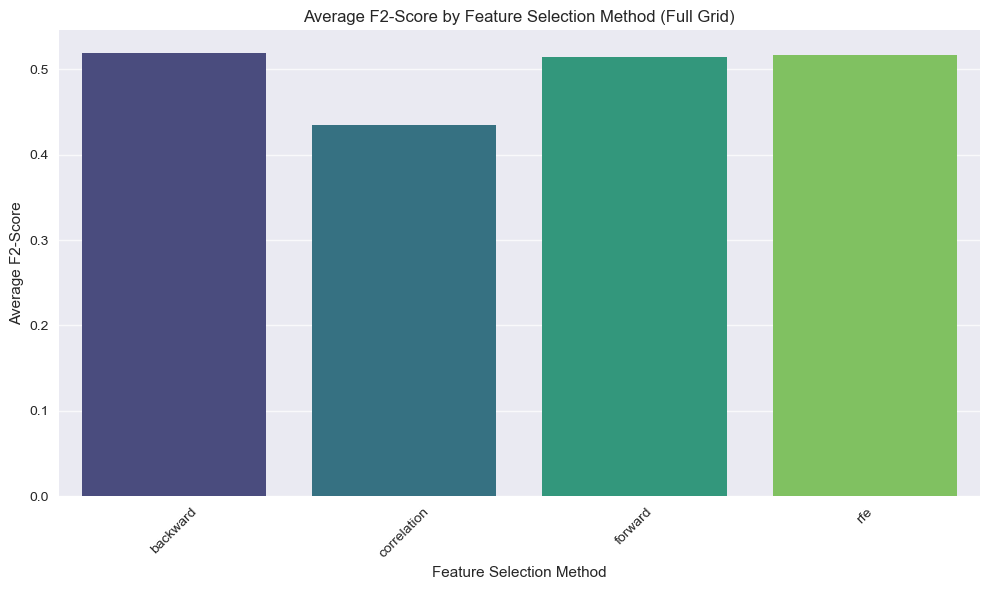

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='feature_selection_method', y='f2_mean', data=fs_method_performance_full_grid, palette='viridis')
plt.title('Average F2-Score by Feature Selection Method (Full Grid)')
plt.xlabel('Feature Selection Method')
plt.ylabel('Average F2-Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

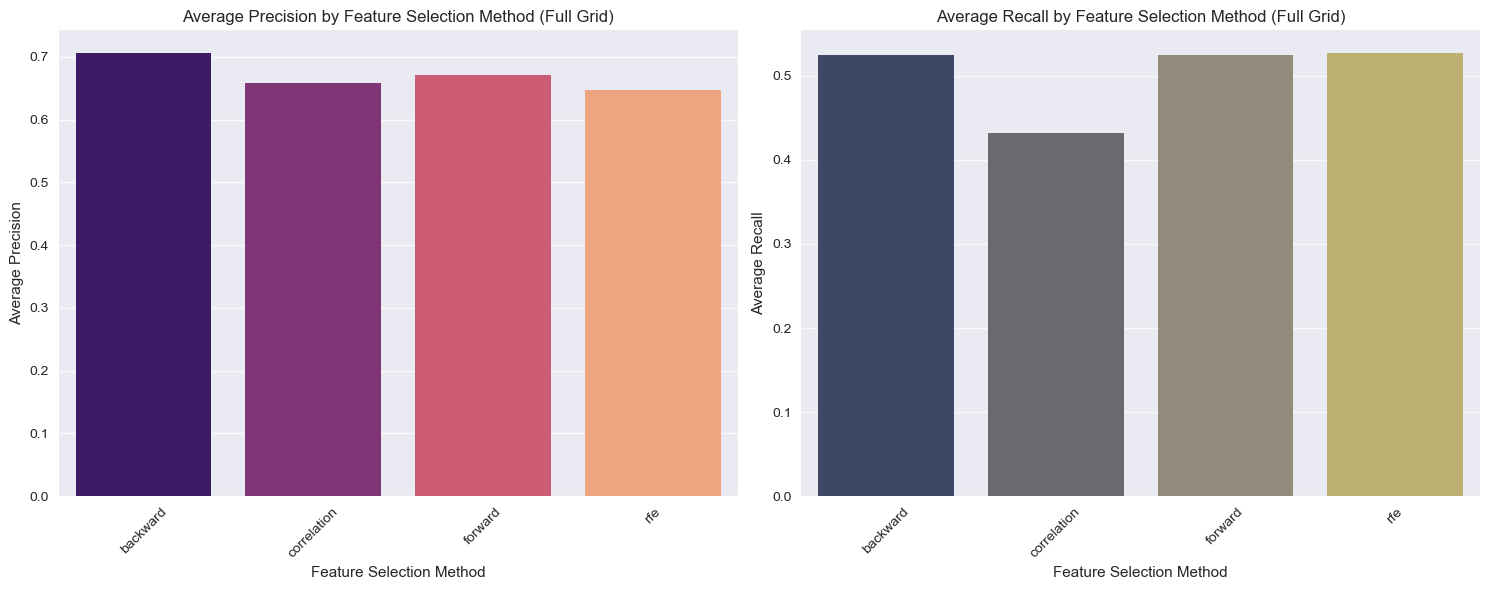

In [17]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='feature_selection_method', y='precision_mean', data=fs_method_performance_full_grid, palette='magma')
plt.title('Average Precision by Feature Selection Method (Full Grid)')
plt.xlabel('Feature Selection Method')
plt.ylabel('Average Precision')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
sns.barplot(x='feature_selection_method', y='recall_mean', data=fs_method_performance_full_grid, palette='cividis')
plt.title('Average Recall by Feature Selection Method (Full Grid)')
plt.xlabel('Feature Selection Method')
plt.ylabel('Average Recall')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [18]:
results_df.to_csv('full_grid_results_detailed.csv', index=False)
best_compromises_full_grid.to_csv('full_grid_best_compromises.csv', index=False)

print("💾 Results saved:")
print("   - full_grid_results_detailed.csv : All detailed experiment results")
print("   - full_grid_best_compromises.csv : Best compromises by model and feature selection method")

💾 Results saved:
   - full_grid_results_detailed.csv : All detailed experiment results
   - full_grid_best_compromises.csv : Best compromises by model and feature selection method
